## 反小孔成像论文部分复现

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as skimage
import scipy

from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse.linalg import lsqr

In [2]:
# window opened images
w_ims = []
# exposure times
w_dts = []

w_ims.append(plt.imread('w0.25.jpg'))
w_dts.append(0.25)

w_ims.append(plt.imread('w0.125.jpg'))
w_dts.append(0.125)

w_ims.append(plt.imread('w0.05.jpg'))
w_dts.append(0.05)

w_ims.append(plt.imread('w0.01.jpg'))
w_dts.append(0.01)


In [3]:
w_ims_r = [img[:, :, 0] for img in w_ims]
w_ims_g = [img[:, :, 1] for img in w_ims]
w_ims_b = [img[:, :, 2] for img in w_ims]

In [4]:
# window closed images
c_ims = []
# exposure times
c_dts = []

c_ims.append(plt.imread('c0.25.jpg'))
c_dts.append(0.25)

c_ims.append(plt.imread('c0.125.jpg'))
c_dts.append(0.125)

c_ims.append(plt.imread('c0.05.jpg'))
c_dts.append(0.05)

c_ims.append(plt.imread('c0.01.jpg'))
c_dts.append(0.01)


In [5]:
c_ims_r = [img[:, :, 0] for img in c_ims]
c_ims_g = [img[:, :, 1] for img in c_ims]
c_ims_b = [img[:, :, 2] for img in c_ims]

In [21]:
# use multy expisure images to build hdr image
def build_hdr(img_list, dts, const):
    [h,w]=img_list[0].shape
    l = len(img_list)
    A = lil_array((l * h * w + 256 + 1, 256 + h * w), dtype=np.float32)
    b = np.zeros(l * h * w + 256 + 1, dtype=np.float32)

    def weight(z):
        if 0 <= z <= 5 or 250 <= z <= 255:
            return 0
        elif 6 <= z <= 126:
            return (z-5) / 121.0
        elif 127 <= z <= 249:
            return (249-z) / 123.0

    row = 0
    for j in range(l):
        for i in range(h):
            for k in range(w):
                Z_ij = img_list[j][i,k]
                w_ij = weight(Z_ij)
                A[row,Z_ij] = w_ij
                A[row,(256 + i * w + k)] = -w_ij
                b[row] = np.float32(np.log(dts[j])) * np.float32(w_ij)
                row += 1

    lambd = 10

    for z in range(1,255):
        A[row-1+z,z-1] = lambd
        A[row-1+z,z] = -2 * lambd
        A[row-1+z,z+1] = 1 * lambd


    A[row+255,128] = 1
    b[row+255] = const

    Acsr = csr_array(A)
    soln = lsqr(Acsr,b,atol=1e-07, btol=1e-07)
    v = soln[0]
    result = np.reshape(v[256:],(h,w)).astype(np.float32)
    
    return result

In [22]:
# map hdr image to sdr that can display
def map_sdr(hdr):
    hdr_min = hdr.min()
    hdr_max = hdr.max()
    result_mapped = (hdr - hdr_min) / (hdr_max - hdr_min)
    gamma_adjust = np.power(result_mapped, 1/2.2)
    result_mapped = np.clip(255 * result_mapped, 0, 255).astype(np.uint8)
    return result_mapped

In [23]:
# build r,g,b channals to hdr windowed image
w_hdr_r = build_hdr(w_ims_r,w_dts,6.5)

In [24]:
w_hdr_g = build_hdr(w_ims_g,w_dts,6.5)

In [25]:
w_hdr_b = build_hdr(w_ims_b,w_dts,7.0)

In [26]:
# map to sdr
w_mapped_r = map_sdr(w_hdr_r)
w_mapped_g = map_sdr(w_hdr_g)
w_mapped_b = map_sdr(w_hdr_b)

In [27]:
# build r,g,b channals to hdr closed image
c_hdr_r = build_hdr(c_ims_r,c_dts,6.5)

In [28]:
c_hdr_g = build_hdr(c_ims_g,c_dts,6.0)

In [29]:
c_hdr_b = build_hdr(c_ims_b,c_dts,7.0)

In [30]:
# map to sdr
c_mapped_r = map_sdr(c_hdr_r)
c_mapped_g = map_sdr(c_hdr_g)
c_mapped_b = map_sdr(c_hdr_b)

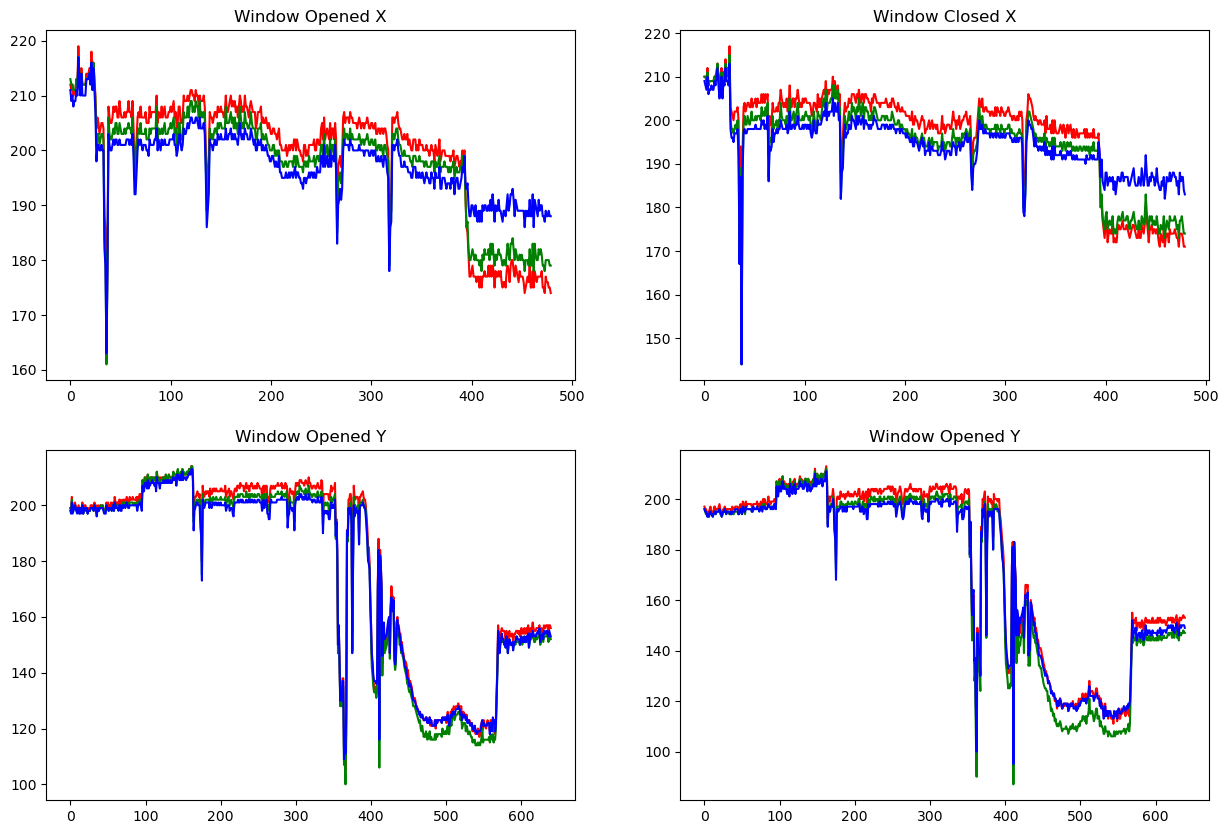

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0,0].plot(w_mapped_r[:,255],'r')
axes[0,0].plot(w_mapped_g[:,255],'g')
axes[0,0].plot(w_mapped_b[:,255],'b')
axes[0,0].set_title('Window Opened X')

axes[0,1].plot(c_mapped_r[:,255],'r')
axes[0,1].plot(c_mapped_g[:,255],'g')
axes[0,1].plot(c_mapped_b[:,255],'b')
axes[0,1].set_title('Window Closed X')

axes[1,0].plot(w_mapped_r[255,:],'r')
axes[1,0].plot(w_mapped_g[255,:],'g')
axes[1,0].plot(w_mapped_b[255,:],'b')
axes[1,0].set_title('Window Opened Y')

axes[1,1].plot(c_mapped_r[255,:],'r')
axes[1,1].plot(c_mapped_g[255,:],'g')
axes[1,1].plot(c_mapped_b[255,:],'b')
axes[1,1].set_title('Window Opened Y')

plt.show()

In [32]:
# get Anti-pinhole image by subtract two hdr image
s_r = np.subtract(w_mapped_r , c_mapped_r)
s_g = np.subtract(w_mapped_g , c_mapped_g)
s_b = np.subtract(w_mapped_b , c_mapped_b)
diff_image = np.stack((s_r, s_g, s_b),axis=2)
diff_image = skimage.exposure.rescale_intensity(diff_image, in_range=(0, np.max(diff_image)))[::-1, ::-1, :]

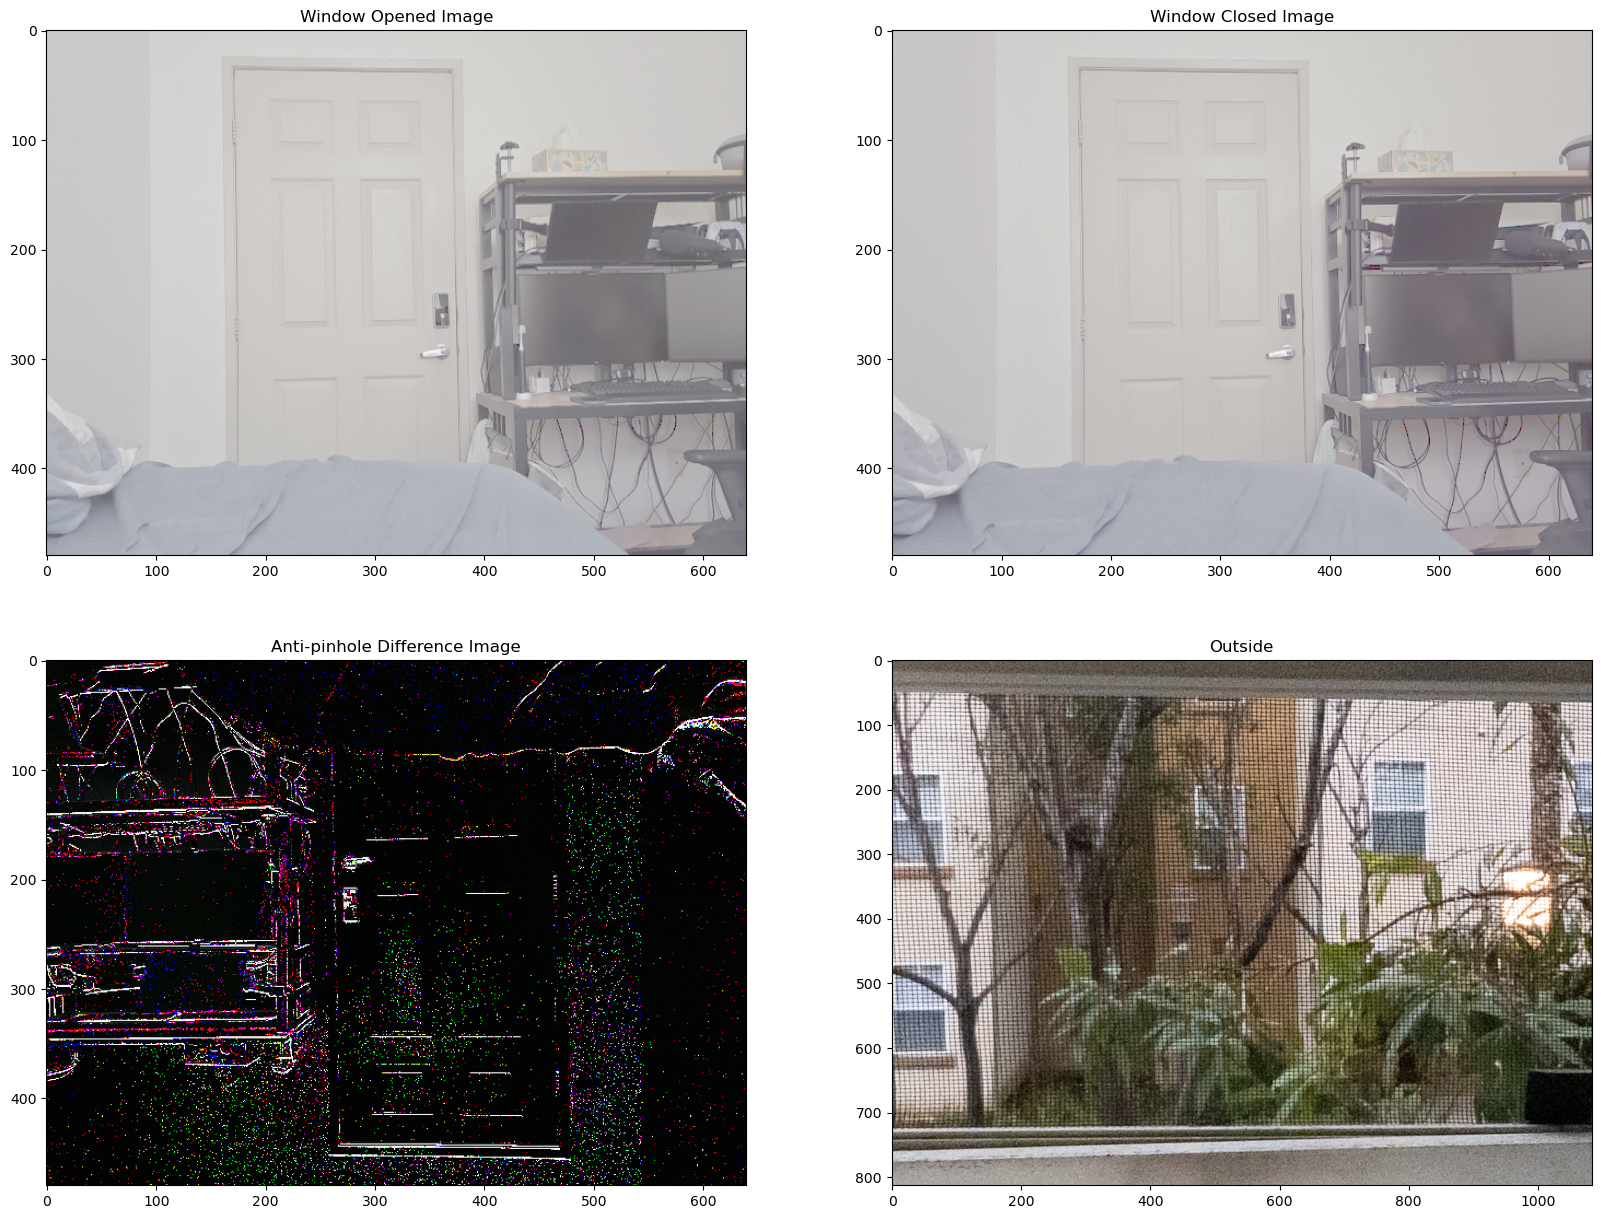

In [33]:
window = plt.imread('window.jpg')
open = np.stack((w_mapped_r, w_mapped_g, w_mapped_b),axis=2)
close = np.stack((c_mapped_r, c_mapped_g, c_mapped_b),axis=2)

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes[0,0].imshow(open)
axes[0,0].set_title('Window Opened Image')

axes[0,1].imshow(close)
axes[0,1].set_title('Window Closed Image')

axes[1,0].imshow(diff_image)
axes[1,0].set_title('Anti-pinhole Difference Image')

axes[1,1].imshow(window)
axes[1,1].set_title('Outside')

plt.show()

In [34]:
# get Anti-pinhole image by subtract two 0.05 exposure sdr image
r = np.subtract(w_ims[2][:, :, 0] , c_ims[2][:, :, 0])
g = np.subtract(w_ims[2][:, :, 1] , c_ims[2][:, :, 1])
b = np.subtract(w_ims[2][:, :, 2] , c_ims[2][:, :, 2])
diff = np.stack((r, g, b),axis=2)
diff = skimage.exposure.rescale_intensity(diff, in_range=(0, np.max(diff)))[::-1, ::-1, :]

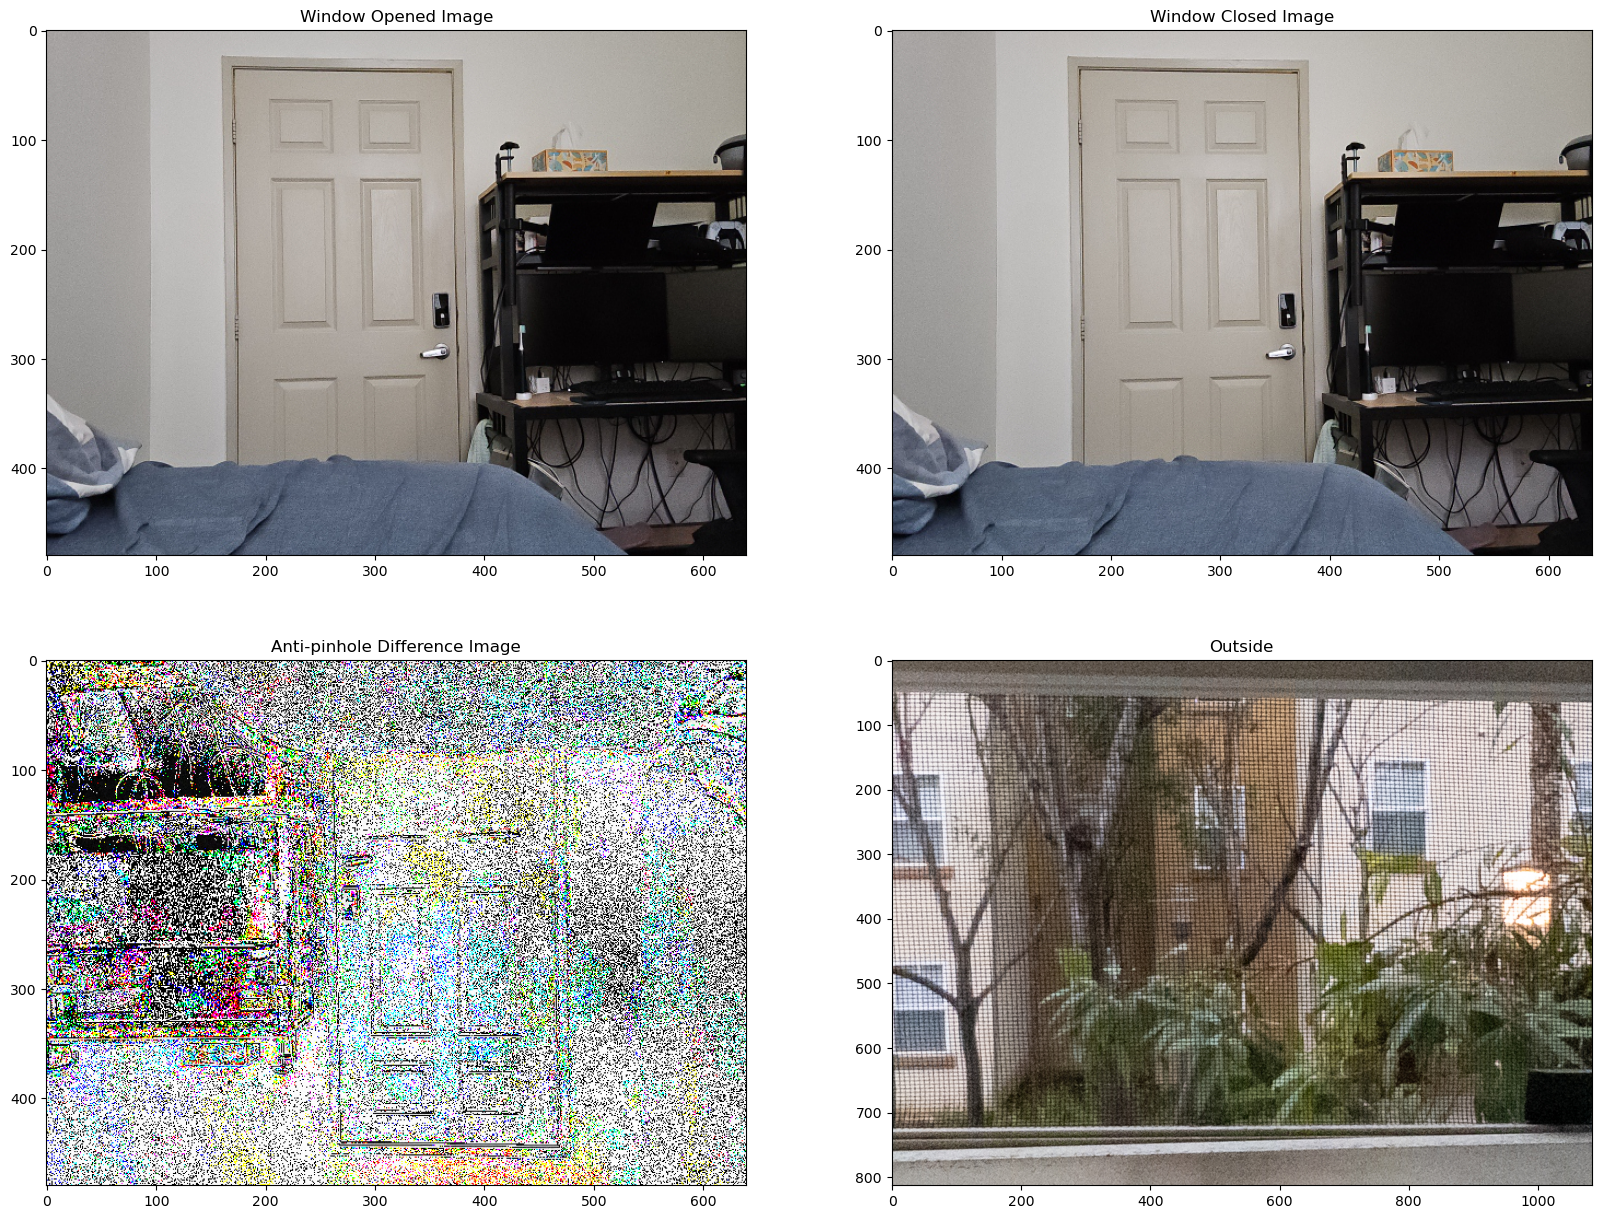

In [20]:
window = plt.imread('window.jpg')

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

axes[0,0].imshow(w_ims[2])
axes[0,0].set_title('Window Opened Image')

axes[0,1].imshow(c_ims[2])
axes[0,1].set_title('Window Closed Image')

axes[1,0].imshow(diff)
axes[1,0].set_title('Anti-pinhole Difference Image')

axes[1,1].imshow(window)
axes[1,1].set_title('Outside')

plt.show()